In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_path = '/content/drive/MyDrive/sem2/quantum computing/project'

Imports

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import multiprocessing
import scipy.ndimage
import skimage
import sklearn.cluster
import scipy.spatial.distance
import os, time
import matplotlib.pyplot as plt
import random
from skimage import io
from keras.datasets import mnist 
import math
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix

Pre-processing [for Mnist dataset](https://machinelearningmastery.com/how-to-normalize-center-and-standardize-images-with-the-imagedatagenerator-in-keras/)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


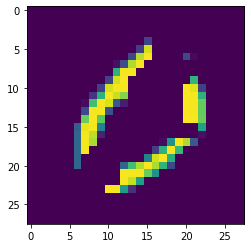

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

datagen = ImageDataGenerator(featurewise_center=True,
                             featurewise_std_normalization=True)
og = X_train[1]
img = datagen.standardize(X_train[1])
operatedImage = np.float32(img) / 255
pts = get_harris_points(operatedImage)
for pt in range(len(pts[0])):
  operatedImage[pts[0][pt],pts[1][pt]] = 0
plt.imshow(operatedImage)

# Feature extraction

Harris corner detector

In [ ]:
def get_harris_points(image,k=0.05):
    from skimage.color import rgb2gray
    from scipy import ndimage


    bw_img = rgb2gray(image)
    Ix = cv2.Sobel(bw_img,cv2.CV_64F,1,0,ksize=3)
    Iy = cv2.Sobel(bw_img,cv2.CV_64F,0,1,ksize=3)
    
    IxIx = scipy.ndimage.filters.gaussian_filter(Ix**2,sigma=1)
    IyIy = scipy.ndimage.filters.gaussian_filter(Iy**2,sigma=1)
    
    IxIy = scipy.ndimage.filters.gaussian_filter(Ix*Iy,sigma=1)
    
    height,width = bw_img.shape
    
    det = IxIx * IyIy - IxIy ** 2
    trace = IxIx + IyIy
    
    R = det - k * trace ** 2
    
    idx = np.argsort(R.ravel(),axis = None)
    idx = idx[-150:]
    
    points_of_interest = [[],[]]
    for id in idx:
        
        x = id // R.shape[1]
        y = id % R.shape[1]
        if R[x][y] >0:
            points_of_interest[0].append(x)
            points_of_interest[1].append(y)
    return points_of_interest


[1 1 1]
[1 1 1]
[0 1 2]


filter responses

In [ ]:
def display_filter_responses(response_maps):
    '''
    Visualizes the filter response maps.

    [input]
    * response_maps: a numpy.ndarray of shape (H, W, 3F)
    '''

    fig = plt.figure(1)

    for i in range(20):
        plt.subplot(5, 4, i+1)
        resp = response_maps[:, :, i]
        resp_min = resp.min(axis=(0, 1), keepdims=True)
        resp_max = resp.max(axis=(0, 1), keepdims=True)
        resp = (resp-resp_min)/(resp_max-resp_min)
        plt.imshow(resp, cmap = 'gray')
        plt.axis("off")

    plt.subplots_adjust(left=0.05,right=0.95,top=0.95,bottom=0.05,wspace=0.05,hspace=0.05)
    plt.show()

Applying different filers on images for edge calculation

In [ ]:
def extract_filter_responses(image):
    '''
    Extracts the filter responses for the given image.

    [input]
    * image: numpy.ndarray of shape (H, W) 

    [output]
    * filter_responses: numpy.ndarray of shape (H, W, F)
    '''

    image = image.astype('float')
    image[image<0.5] = 0
    filter_responses = []
    
    for scale in [1,2,4,8,8*np.sqrt(2)]:
        #(1) Gaussian, (2) Laplacian of Gaussian, (3) derivative of Gaussian in the  𝑥  direction, and (4) derivative of Gaussian in the  𝑦  direction.
        r = scipy.ndimage.gaussian_filter(image,scale)
        gaussian = np.dstack([r])
        
        r = scipy.ndimage.gaussian_laplace(image,scale)
        laplace = np.dstack([r])
        
        r = scipy.ndimage.filters.gaussian_filter(image,(scale,scale),(1,0))
        y_dir = np.dstack([r])

        r = scipy.ndimage.filters.gaussian_filter(image,(scale,scale),(0,1))
        x_dir = np.dstack([r])
        
        if len(filter_responses) != 0:
            filter_responses = np.dstack([filter_responses, gaussian,laplace,x_dir,y_dir])
        else:
            filter_responses = np.dstack([gaussian,laplace,x_dir,y_dir])
    return filter_responses 

Compare the image with filter responses and detect the common edge points

In [ ]:
def compute_dictionary_one_image(args):
    '''
    Extracts samples of the dictionary entries from an image. Use the the 
    harris corner detector implmented from previous question to extract 
    the point of interests. This should be a function run by a subprocess.

    [input]
    * i: index of training image
    * image_path: image

    [saved]
    * sampled_response: numpy.ndarray of shape (alpha, 3F)
    '''
    i, image = args
    if not os.path.isdir('tmp'):
        os.mkdir('tmp')

    f_name = drive_path+'/tmp/%05d.npy' % i

    harris_points = get_harris_points(image)
    filter_responses = extract_filter_responses(image)
    sampled_responses = np.zeros(( len(harris_points[0]),filter_responses.shape[2] ))

    for i in range(len(harris_points[0])):
        y,x = harris_points[0][i], harris_points[1][i]
        for n in range(filter_responses.shape[2]):
            sampled_responses[i,n] = filter_responses[y,x,n]
    np.save(f_name,sampled_responses)

---

Training dataset processing


---



In [ ]:
def compute_dictionary(num_workers=2):
    '''
    Creates the dictionary of visual words by clustering using k-means.

    [input]
    * num_workers: number of workers to process in parallel

    [saved]
    * dictionary: numpy.ndarray of shape (K,F)
    '''
    # ----- TODO -----
    list_of_args = []

    n_clusters = 8


    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    num_images = len(X_train)
    datagen = ImageDataGenerator(featurewise_center=True,
                             featurewise_std_normalization=True)

    for i in range(num_images):
        img = datagen.standardize(X_train[i])
        operatedImage = np.float32(img) / 255
        list_of_args.append([i, operatedImage])

    with multiprocessing.Pool(num_workers) as p:
        p.map(compute_dictionary_one_image, list_of_args)

    filter_responses = []
    for file_name in os.listdir(drive_path+'/tmp'):
        cur = np.load(drive_path+'/tmp/'+file_name)
        if len(filter_responses) == 0:
            filter_responses = cur
        else:
            filter_responses = np.vstack([filter_responses,cur])

    kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters).fit(filter_responses)
    dictionary = kmeans.cluster_centers_ 
    np.save(drive_path+'/dictionary.npy', dictionary)

In [ ]:
# compute_dictionary(4)

# Histogram Generation



---
Sptial Pyramid Matching


In [ ]:
def get_visual_words(image, dictionary):
    filter_responses = extract_filter_responses(image)
    h, w, F = filter_responses.shape
    
    wordMap = np.zeros((h,w))
    for y in range(h):
        for x in range(w):
            filters = np.array([filter_responses[y][x][n] for n in range(F)]) # 1* 3F
            dist = scipy.spatial.distance.cdist(dictionary,[filters],metric='euclidean')
            wordMap[y][x] = np.argmin(dist)
    return wordMap

In [ ]:
def get_feature_from_wordmap(wordmap, dict_size):
    wordmap = wordmap.flatten()
    hist = np.histogram(wordmap,range(dict_size+1),density=True)
    return hist[0]

In [ ]:
def get_feature_from_wordmap_SPM(wordmap, layer_num, dict_size):
    h, w = wordmap.shape
    L = layer_num - 1
    patch_width = math.floor(w / (2**L))
    patch_height = math.floor(h / (2**L))
    hist_all = np.zeros((dict_size,int((4**(L+1) - 1)/3)))
    weight,i = 4,0
    metadata = [( 0 , 1.0/weight )]
    while i < L:
        metadata.append( ( (metadata[-1][0]+ 4**i) , 1.0/weight ) )
        weight/=2
        i += 1
    for l in range(L,-1,-1):
        if l == L:
            step = 0
            h_step,w_step = int(h // 2**l), int(w // 2**l)
            for cur_h in range(0,h_step*2**l,h_step):
                for cur_w in range(0,w_step*2**l,w_step):
                    cur_word = wordmap[cur_h:cur_h+h_step ,cur_w:cur_w+w_step]
                    hist = get_feature_from_wordmap(cur_word,dict_size)
                    hist_all[:,metadata[l][0]+step] = hist
                    step += 1
        else:
            arr = np.array(range(4**(l+1))).reshape(2**(l+1),2**(l+1))
            arr += metadata[l+1][0]
            step = metadata[l][0]
            for h in range(0,arr.shape[0],2):
                for w in range(0,arr.shape[1],2):
                    cur = hist_all[:,arr[h:h+2,w:w+2].reshape(-1)]
                    hist_all[:,step] = np.sum(cur,axis=1)
                    step += 1
    for l in range(L+1):
        start_idx,weight = metadata[l]
        total_cols = 4**l
        hist_all[:,start_idx:start_idx+total_cols] *= weight
    
    hist_all = hist_all.ravel()
    normalized_v = normalize(hist_all[:,np.newaxis], axis=0,norm ='l1').ravel()
    return normalized_v


Running threads to convert all images into histograms

In [ ]:
def get_image_feature(args):
    i, dictionary, layer_num, K,image = args
    wordmap = get_visual_words(image,dictionary)
    feature = get_feature_from_wordmap_SPM(wordmap, layer_num, K)
    return [i, feature]

def build_recognition_system(num_workers=2):
    dictionary = np.load(drive_path+"/dictionary.npy")
    SPM_layer_num = 3
    K = dictionary.shape[0]

    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    labels = y_train
    num_images = len(X_train)
    # num_images = 2
    datagen = ImageDataGenerator(featurewise_center=True,
                             featurewise_std_normalization=True)
    list_of_args = []
    for i in range(num_images):
        img = datagen.standardize(X_train[i])
        operatedImage = np.float32(img) / 255
        list_of_args.append([i,dictionary,SPM_layer_num,K,operatedImage])

    with multiprocessing.Pool(num_workers) as p:
        features = p.map(get_image_feature, list_of_args)


    ordered_features = [None]* (num_images)
    for entry in features:
      ordered_features[entry[0]] = entry[1]
    
    ordered_features = np.array(ordered_features)
        
    np.savez('trained_system.npz', features=ordered_features,
                                    labels=labels,
                                    dictionary=dictionary,
                                    SPM_layer_num=SPM_layer_num)

In [ ]:
# build_recognition_system()

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


# Prediction of test set

In [ ]:
def distance_to_set(word_hist, histograms):
    return np.sum(np.minimum(word_hist,histograms),axis=1)

In [163]:
def helper_func(args):
    i, dictionary, layer_num, K, trained_features, train_labels,image = args

    args2 = i, dictionary, layer_num, K,image
    feature = get_image_feature(args2)
    feature = np.array(feature[1])
    nearest_image_idx = np.argmax(distance_to_set(trained_features,feature))
    pred_label = train_labels[nearest_image_idx]
    return [i, pred_label, nearest_image_idx]


def evaluate_recognition_system(num_workers=2):
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    trained_system = np.load("trained_system.npz")
    
    images = X_test
    test_labels = y_test

    trained_features = trained_system['features']
    train_labels = trained_system['labels']
    dictionary = trained_system['dictionary']
    SPM_layer_num = trained_system['SPM_layer_num']
    SPM_layer_num = int(SPM_layer_num)
    K = dictionary.shape[0]

    print("Trained features shape: ", trained_features.shape)

    list_of_args = []
    num_images = len(images)
    # num_images = 2
    for i in range(num_images):
        list_of_args.append([i, dictionary, SPM_layer_num, K, trained_features, train_labels,images[i]])
    
    p = multiprocessing.Pool(num_workers)
    labels = p.map_async(helper_func, list_of_args)

    while not labels.ready():
        print('pending '+str(labels._number_left * labels._chunksize))
        time.sleep(60)

    labels = labels.get()
    ordered_labels = [None] * len(labels)
    for label in labels:
        ordered_labels[label[0]] = label[1]
    
    ordered_labels = np.array(ordered_labels, dtype=int)
    print("Predicted labels shape: ", ordered_labels.shape)
    conf_matrix = confusion_matrix(test_labels, ordered_labels)
    accuracy = np.sum(conf_matrix.diagonal())/conf_matrix.sum()
    np.save("./conf_matrix.npy",conf_matrix)
    return conf_matrix, accuracy

In [ ]:
evaluate_recognition_system()

Trained features shape:  (60000, 168)
pending 10000
pending 10000
pending 10000
pending 10000
pending 10000
pending 10000
pending 10000
pending 7500
pending 7500
pending 7500
pending 7500
pending 7500
pending 7500
pending 5000
pending 5000
pending 5000
pending 5000
pending 5000
pending 5000
pending 5000
pending 5000
pending 2500
pending 2500
pending 2500
pending 2500
pending 2500
pending 2500
pending 2500
pending 2500
Predicted labels shape:  (10000,)


(array([[575,   0,   0,   0,   0, 405,   0,   0,   0,   0],
        [  0, 698,   0,   0,   0, 437,   0,   0,   0,   0],
        [  0,   0, 645,   0,   0, 387,   0,   0,   0,   0],
        [  0,   0,   0, 607,   0, 403,   0,   0,   0,   0],
        [  0,   0,   0,   0, 622, 360,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0, 892,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0, 365, 593,   0,   0,   0],
        [  0,   0,   0,   0,   0, 418,   0, 610,   0,   0],
        [  0,   0,   0,   0,   0, 404,   0,   0, 570,   0],
        [  0,   0,   0,   0,   0, 383,   0,   0,   0, 626]]), 0.6438)